In [1]:
# %load_ext rpy2.ipython
# %load_ext RWinOut # hack to see the output, https://github.com/vitorcurtis/RWinOut

In [2]:
from itertools import product, accumulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress, ttest_ind, ttest_rel

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem.Descriptors as D

from tqdm import tqdm_notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Load the data

In [7]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

In [4]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [8]:
df_join = df_activity.join(df_molecules_std, on='std_inchi_key')

In [10]:
df_join.rename(lambda x:x.replace('pChEMBL_Value', 'activity'), axis='columns', inplace=True)

In [11]:
df_join.head()

,receptor_name,Standard_Value,activity,std_smiles,std_inchi,std_morgan_fp,scaffold_smiles,scaffold_inchi,scaffold_inchi_key,scaffold_morgan_fp
std_inchi_key,,,,,,,,,,
AACVSEPXXNRBIR-UHFFFAOYSA-N,PR,16.4,7.790,COC1Oc2ccc(Cl)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3,"InChI=1S/C20H20ClNO2/c1-11-10-20(2,3)22-15-7-6...",0000000000010000000000000000000001001000000000...,C1CCC2C(C1)CCC1C3CCCCC3CCC21,InChI=1S/C18H30/c1-3-7-15-13(5-1)9-11-18-16-8-...,ZEMKTMFBYLHVNN-UHFFFAOYSA-N,0000100000000000000000000000000000000000000000...
AADGIVANXMJZCW-HFPMIOGFSA-N,MR,7025.0,6.075,CC(=O)C1CC[C@H]2[C@@H]3CC=C4CC(=O)CC[C@]4(C)[C...,InChI=1S/C21H30O3/c1-12(22)16-6-7-17-15-5-4-13...,0000000000000000000000000000000001001000000000...,CC1CCC2C(CCC3C4CCCC4CCC23)C1,InChI=1S/C18H30/c1-12-5-8-16-14(11-12)7-10-17-...,YPLIQZFPBOSWDU-UHFFFAOYSA-N,0000100000000000000000000000000001000001000000...
AAJNWJFLYOFHIB-UHFFFAOYSA-N,MR,320.0,6.500,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,C1CCC(CCCCC2CCCCC2)CC1,InChI=1S/C16H30/c1-3-9-15(10-4-1)13-7-8-14-16-...,UWSSRUCETFDRMI-UHFFFAOYSA-N,0010100000000000000000000000010000000000000000...
AAJNWJFLYOFHIB-UHFFFAOYSA-N,PR,140.0,6.850,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,C1CCC(CCCCC2CCCCC2)CC1,InChI=1S/C16H30/c1-3-9-15(10-4-1)13-7-8-14-16-...,UWSSRUCETFDRMI-UHFFFAOYSA-N,0010100000000000000000000000010000000000000000...
AAPVCQWLJSSUGW-UHFFFAOYSA-N,AR,19000.0,4.720,Cc1ccccc1OCCSc1nc2ccccc2[nH]1,InChI=1S/C16H16N2OS/c1-12-6-2-5-9-15(12)19-10-...,0000000000000100000000000000000001000000000000...,C1CCC(CCCCC2CC3CCCCC3C2)CC1,InChI=1S/C19H34/c1-2-8-16(9-3-1)10-4-5-11-17-1...,ZMJCPEXMFCFNMF-UHFFFAOYSA-N,0010100000000000000000000000010000000000000000...


## Exploratory analysis

In [12]:
def plot_kde(x, num_points=1000, *args, **kwargs):
    density = gaussian_kde(x)
    x = np.linspace(np.min(x), np.max(x), num_points)
    plt.plot(x, density(x), *args, **kwargs)

In [13]:
def plot_kde_2d(p_x,p_y, num_points=100, bw_method=None, *args, **kwargs):
    density = gaussian_kde(np.c_[p_x, p_y].T, bw_method)
    x,y = np.linspace(np.min(p_x),np.max(p_x), num_points), np.linspace(np.min(p_y), np.max(p_y), num_points)
    z = density(np.asarray(list(product(x,y))).T).reshape(num_points,num_points).T
#     z = density(list(zip(*product(x,y)))).reshape(num_points,num_points).T
    plt.pcolormesh(x,y,z, *args, **kwargs)

In [14]:
from matplotlib import cm

def make_colormap(x, colormap=cm.plasma):
    return colormap(np.int64(minmax_scale(x)*255))

def plot_scatter_colormap(x,y,z,alpha=0.25,*args,**kwargs):
#     plt.figure()
    plt.scatter(x,y, c=make_colormap(z), alpha=alpha, *args, **kwargs)
    plt.figure()
    plt.axis('off')
    plt.imshow(np.expand_dims(np.asarray(cm.plasma.colors),0),aspect=10)

In [15]:
def plot_linear_regression(x,y,alpha=0.1,*args,**kwargs):
    lr = linregress(x,y)
    plt.scatter(x, y, alpha=alpha,*args,**kwargs)
    min_x = np.min(x)
    max_x = np.max(x)
    line_x = np.asarray([min_x, max_x])
    line_y = lr.intercept + lr.slope*line_x
    plt.plot(line_x, line_y, '--', c='black')
    plt.title('r=%.3f, p=%e, stderr=%.3f' % (lr.rvalue, lr.pvalue, lr.stderr))

Text(0.5, 1.0, 'Number of atoms (log10)')

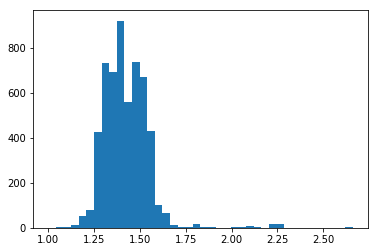

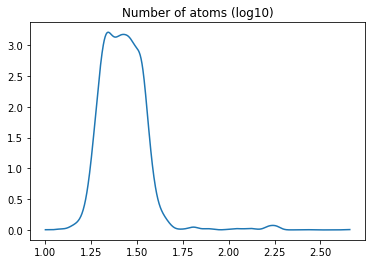

In [16]:
plt.hist(np.log10([x.GetNumAtoms() for x in std_mols_clean]), bins=40)
plt.figure()
plot_kde(np.log10([x.GetNumAtoms() for x in std_mols_clean]))
plt.title('Number of atoms (log10)')

Text(0.5, 1.0, 'activity')

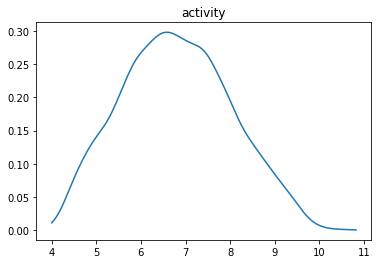

In [21]:
plot_kde(df_join.activity)
plt.title('activity')

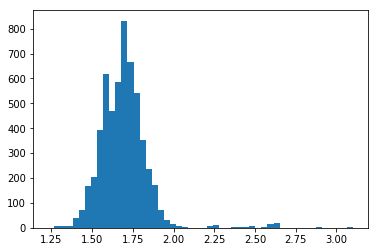

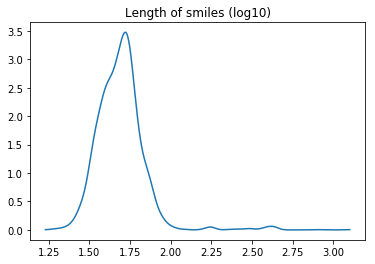

In [19]:
plt.hist(np.log10(list(map(len,df_molecules_std.std_smiles))), bins=50)
plt.figure()
plot_kde(np.log10(list(map(len,df_molecules_std.std_smiles))))
plt.title('Length of smiles (log10)');

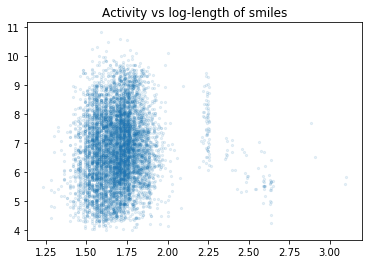

In [23]:
plt.scatter(np.log10(list(map(len,df_join.std_smiles))), df_join.activity, alpha=0.1, s=5)
plt.title('Activity vs log-length of smiles');

Text(0.5, 1.0, 'Activity vs log-length of smiles')

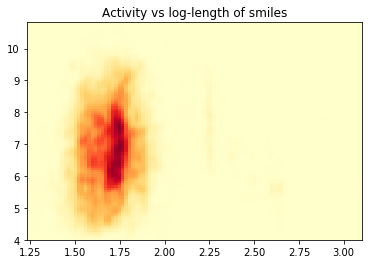

In [24]:
plot_kde_2d(np.log10(list(map(len,df_join.std_smiles))), df_join.activity, num_points=100, bw_method=0.1, cmap='YlOrRd')
plt.title('Activity vs log-length of smiles')

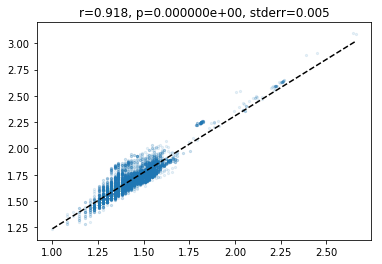

In [25]:
plot_linear_regression(np.log10([MolFromSmiles(x).GetNumAtoms() for x in df_join.std_smiles]), np.log10(list(map(len,df_join.std_smiles))), alpha=0.1, s=5)
# plt.title('Length of smiles vs Number of atoms (log-log)')

# Analysis of promiscuity

In [29]:
df_activity_wide = df_join.reset_index().pivot('std_inchi_key','receptor_name')['activity'].copy()

In [34]:
df_activity_wide.head()

receptor_name,AR,ERa,ERb,MR,PR
std_inchi_key,,,,,
AACVSEPXXNRBIR-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,7.79
AADGIVANXMJZCW-HFPMIOGFSA-N,NaN,NaN,NaN,6.075,NaN
AAJNWJFLYOFHIB-UHFFFAOYSA-N,NaN,NaN,NaN,6.500,6.85
AAPVCQWLJSSUGW-UHFFFAOYSA-N,4.72,NaN,NaN,NaN,NaN
AAQPJNXQFGYYCM-UHFFFAOYSA-N,NaN,4.41,NaN,NaN,NaN


In [43]:
df_activity_wide_t = df_activity_wide.applymap(lambda x:x if np.isnan(x) else [0.0,1.0][x>7])

In [52]:
display(df_activity_wide.corr(method='pearson').style.background_gradient(cmap='Blues'))
display(df_activity_wide_t.corr(method='pearson').style.background_gradient(cmap='Blues'))

receptor_name,AR,ERa,ERb,MR,PR
receptor_name,,,,,
AR,1,0.381635,0.43549,0.076974,0.195173
ERa,0.381635,1,0.555142,-0.078861,0.716867
ERb,0.43549,0.555142,1,-0.366357,0.724993
MR,0.076974,-0.078861,-0.366357,1,0.0477185
PR,0.195173,0.716867,0.724993,0.0477185,1


receptor_name,AR,ERa,ERb,MR,PR
receptor_name,,,,,
AR,1,0.429844,0.229117,-0.0681465,0.150546
ERa,0.429844,1,0.281208,-0.250743,0.47151
ERb,0.229117,0.281208,1,-0.223607,0.573489
MR,-0.0681465,-0.250743,-0.223607,1,0.0582286
PR,0.150546,0.47151,0.573489,0.0582286,1


In [53]:
r1,r2='ERa,PR'.split(',')
(df_activity_wide[[r1,r2]].query('{}.notnull() and {}.notnull()'.format(r1,r2))>7).corr(method='pearson')

receptor_name,ERa,PR
receptor_name,,
ERa,1.00000,0.47151
PR,0.47151,1.00000


In [69]:
df_ttest = df_corr.copy()
for r1 in df_corr.columns:
    for r2 in df_corr.columns:
        if r1 == r2:
            t,p = None,1
        else:
            df = df_activity_wide_t[[r1,r2]].query('{}.notnull() and {}.notnull()'.format(r1,r2))
            a,b = df[r1],df[r2]
            df_ttest[r1][r2] = np.sum(np.logical_and(a, b))/np.sum(a)
#             df_ttest[r1][r2] = np.sum(a*b)/np.sum(a)

df_ttest.style.background_gradient(cmap='Blues')

receptor_name,AR,ERa,ERb,MR,PR
receptor_name,,,,,
AR,1,0.705882,0.483871,0.178571,0.324841
ERa,0.5,1,0.561558,0.166667,0.740741
ERb,0.576923,0.71865,1,0.142857,0.588235
MR,0.322581,0.125,0.166667,1,0.351351
PR,0.593023,0.740741,0.909091,0.262626,1


# Analysis of ERa ligands

In [70]:
df_era = df_join.query('receptor_name == "ERa"').copy()

In [71]:
df_era['active'] = df_era.Standard_Value < 100

In [72]:
fps          = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.std_morgan_fp])
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.scaffold_morgan_fp])

## Principal component analysis

In [73]:
pca = PCA()
pc = pca.fit_transform(fps)
pca_scaffold = PCA()
pc_scaffold = pca_scaffold.fit_transform(scaffold_fps)

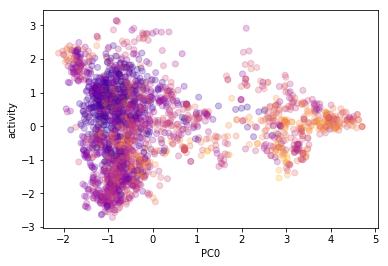

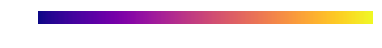

In [74]:
plt.xlabel('PC0')
plt.ylabel('activity')
plot_scatter_colormap(pc[:,0], pc[:,1], df_era.activity)

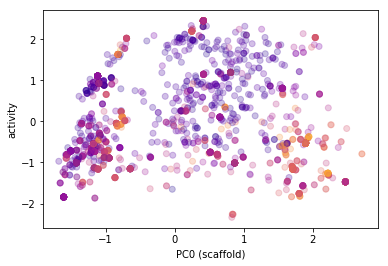

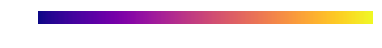

In [75]:
plt.xlabel('PC0 (scaffold)')
plt.ylabel('activity')
plot_scatter_colormap(pc_scaffold[:,0], pc_scaffold[:,1],df_era.activity)

## Principal component regression analysis

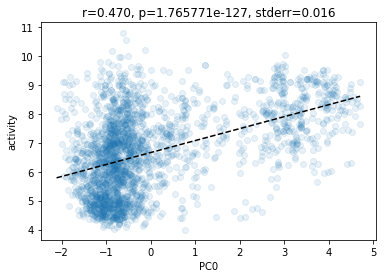

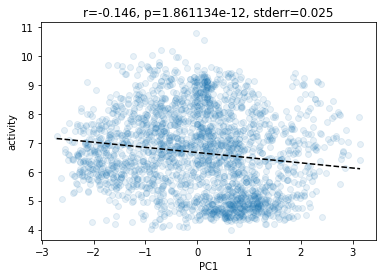

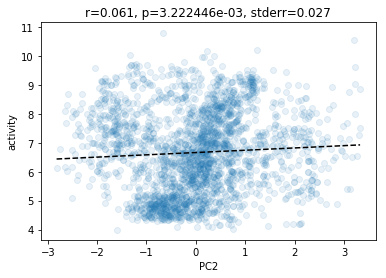

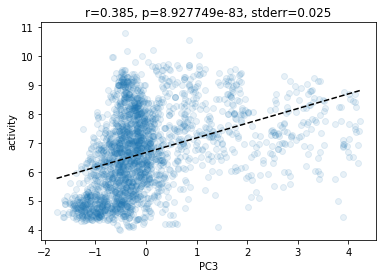

In [76]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc[:,i], df_era.activity)
    plt.xlabel('PC%d' % i)
    plt.ylabel('activity')

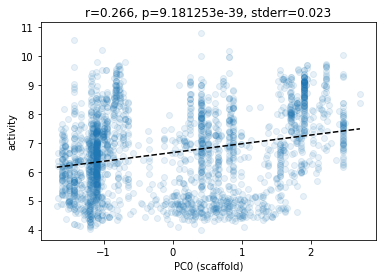

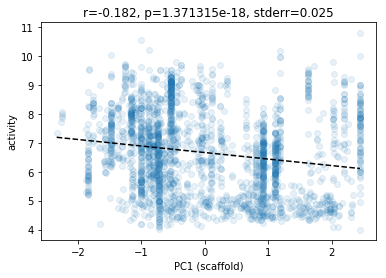

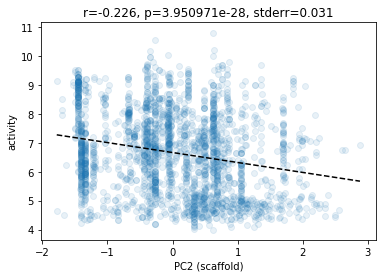

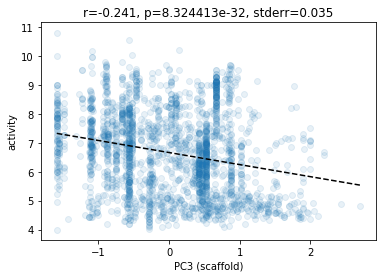

In [77]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc_scaffold[:,i], df_era.activity)
    plt.xlabel('PC%d (scaffold)' % i)
    plt.ylabel('activity')

# Linear regression on whole fingerprint

In [78]:
lr = LinearRegression()
lr.fit(fps, df_era.activity)
r2 = lr.score(fps, df_era.activity)
np.sqrt(r2)

0.9331950779290626

In [79]:
lr = LinearRegression()
lr.fit(scaffold_fps, df_era.activity)
r2 = lr.score(scaffold_fps, df_era.activity)
np.sqrt(r2)

0.8058544928216339

In [80]:
rs = []
for nc in tqdm_notebook(range(1,300)):
    lr = LinearRegression()
    lr.fit(pc[:,:nc], df_era.activity)
    r2 = lr.score(pc[:,:nc], df_era.activity)
    rs.append(np.sqrt(r2))

In [82]:
rs_scaffold = []
for nc in tqdm_notebook(range(1,300)):
    lr = LinearRegression()
    lr.fit(pc_scaffold[:,:nc], df_era.activity)
    r2 = lr.score(pc_scaffold[:,:nc], df_era.activity)
    rs_scaffold.append(np.sqrt(r2))

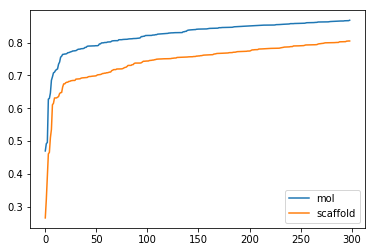

In [83]:
plt.plot(np.asarray(rs)**1, label='mol')
plt.plot(np.asarray(rs_scaffold)**1, label='scaffold')
plt.legend()

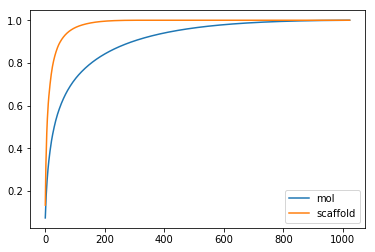

In [84]:
plt.plot(list(accumulate(pca.explained_variance_ratio_)), label='mol')
plt.plot(list(accumulate(pca_scaffold.explained_variance_ratio_)), label='scaffold')
plt.legend()

In [85]:
len(df_era), len(set(df_era.std_smiles)), len(set(df_era.std_morgan_fp)), len(set(df_era.scaffold_smiles)), len(set(df_era.scaffold_morgan_fp))

(2313, 2313, 2194, 709, 632)

## ANOVA on ERa

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [88]:
mod = ols('activity ~ scaffold_smiles', data=df_era).fit()

In [89]:
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
scaffold_smiles,707.0,3540.955009,5.008423,7.492913,1.697092e-242
Residual,1604.0,1072.147844,0.668421,NaN,NaN


In [90]:
df_t2 = mod.summary2().tables[1]

In [91]:
df_t2_ = df_t2[df_t2['P>|t|'] < 0.05].reset_index().sort_values('P>|t|')

In [92]:
df_t2_['smiles'] = df_t2_['index'].apply(lambda x:x.replace('scaffold_smiles[T.','')[:-1])

In [93]:
scaffold_counts = df_era \
    .join(df_t2_.set_index('smiles'), on='scaffold_smiles') \
    .reset_index() \
    .groupby('scaffold_smiles') \
    .aggregate('count')['std_inchi_key'] \
    .to_frame() \
    .rename(lambda x:x.replace('std_inchi_key', 'count'), axis='columns')

In [94]:
df_t2_.join(scaffold_counts, on='smiles').drop('index',axis='columns').sort_values('count', ascending=False)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],smiles,count
48,2.047125,0.822664,2.488409,1.293243e-02,0.433515,3.660735,C1CCC(CC(C2CCCCC2)C2CCCCC2)CC1,80.0
70,2.846909,0.824969,3.450927,5.731528e-04,1.228778,4.465040,C1CCC(CCCC2CCC(C3CC4CCCCC4CC3C3CCCCC3)CC2)CC1,55.0
31,3.539239,0.826409,4.282671,1.956143e-05,1.918284,5.160195,C1CCC(C2CC3CCCCC3CC2C2CCC(CCCC3CCCC3)CC2)CC1,46.0
50,1.775814,0.827022,2.147238,3.192383e-02,0.153656,3.397972,C1CCC(CC2C3CCCCC3CC2C2CCCCC2)CC1,43.0
78,1.987000,0.827727,2.400550,1.648376e-02,0.363460,3.610540,C1CCC(CCCC2CCC(CC3C4CCCCC4CC3C3CCCCC3)CC2)CC1,40.0
37,1.804737,0.828258,2.178955,2.948014e-02,0.180155,3.429319,C1CCC(C2CCC3CCCCC3C2C2CCCCC2)CC1,38.0
57,2.003056,0.828848,2.416675,1.577399e-02,0.377317,3.628794,C1CCC(CCC2CCCCC2)CC1,36.0
133,1.643000,0.829168,1.981505,4.770516e-02,0.016634,3.269366,CC1CC2CCCCC2C(CC2CCCCC2)C1C1CCCCC1,35.0
40,2.211607,0.832042,2.658048,7.937557e-03,0.579604,3.843611,C1CCC(C2CCCC3CCCCC32)CC1,28.0
2,3.415185,0.832573,4.101965,4.302006e-05,1.782140,5.048230,C1CCC(C(C2CCCCC2)C2C3CC4CC(C3)CC2C4)CC1,27.0


In [95]:
smiles = df_t2_.join(scaffold_counts, on='smiles').sort_values('count', ascending=False).smiles[:24]

In [96]:
mols = map(MolFromSmiles, smiles)

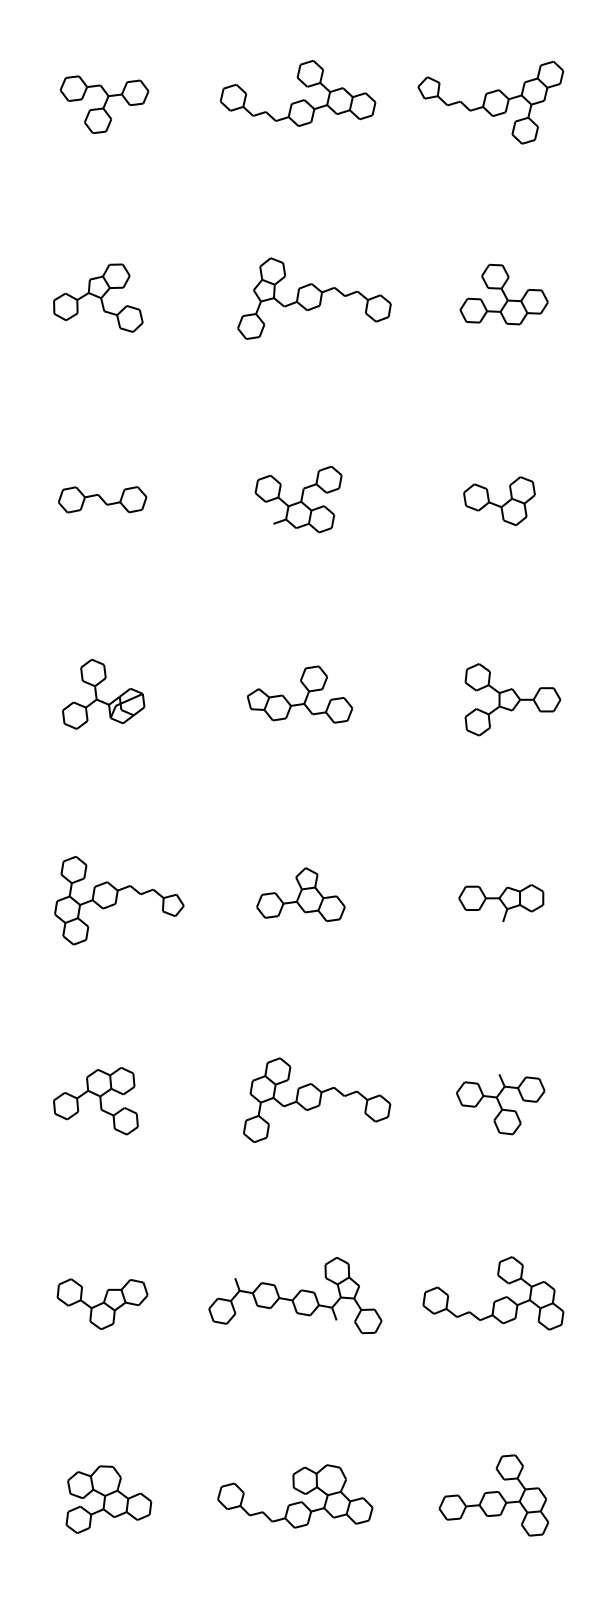

In [97]:
Chem.Draw.MolsToGridImage(list(mols))

# Scaffold clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [98]:
df_molecules_std.scaffold_smiles.fillna('', inplace=True)

In [99]:
df_scaffolds = df_molecules_std.reset_index()[['scaffold_inchi_key', 'scaffold_smiles', 'scaffold_morgan_fp']].drop_duplicates().copy()

In [100]:
df_scaffolds['mol'] = list(map(MolFromSmiles, df_scaffolds.scaffold_smiles))

In [101]:
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_scaffolds.scaffold_morgan_fp])

In [107]:
z = linkage(scaffold_fps, method='ward', metric='euclidean')

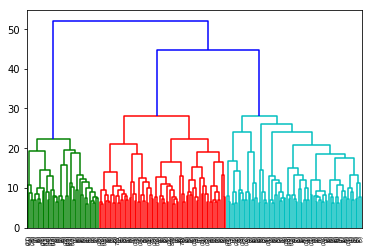

In [108]:
dendrogram(z, truncate_mode='lastp', p=200);

## Choosing the optimal number of clusters

### Best ANOVA p-value

In [300]:
p_values = []
clust_sizes = range(10,800,1)
label_names = []
real_clust_sizes = []
last_k = -1
for n_clust in tqdm_notebook(clust_sizes):
    labels = fcluster(z, criterion='maxclust', t=n_clust)
    k = len(set(labels))
    if k == last_k:
        continue
    real_clust_sizes.append(k)
    last_k = k
    label_names = np.asarray(['label_'+str(x) for x in labels])
    df_scaffolds['cluster_label'] = label_names
    df_era_scaffolds = df_era.join(df_scaffolds.set_index('scaffold_smiles'), on='scaffold_smiles', lsuffix='_l')
    mod = ols('activity ~ cluster_label', data=df_era_scaffolds).fit()
    anova_result = sm.stats.anova_lm(mod, typ=1)
    p_value = anova_result['PR(>F)']['cluster_label']
    p_values.append(p_value)
    
p_values = np.asarray(p_values)

f:\programy\Miniconda3\envs\main\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


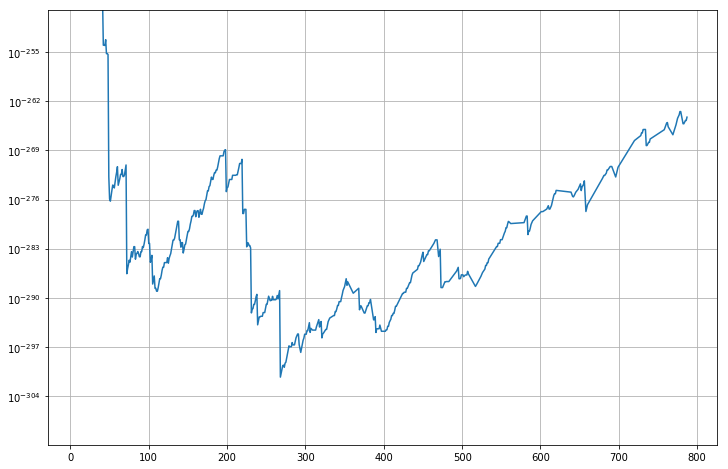

In [301]:
plt.figure(figsize=(12,8))
plt.semilogy(real_clust_sizes, p_values)
plt.ylim(0,10e-250)
plt.grid()

### The elbow method


In [241]:
d2 = pairwise_distances(scaffold_fps, metric='euclidean')**2
d2_sum = np.sum(d2)

In [263]:
VRC_values = []
clust_sizes = range(2,len(z),1)
real_clust_sizes = []
last_k = -1
for n_clust in tqdm_notebook(clust_sizes):
    labels = fcluster(z, criterion='maxclust', t=n_clust)
    k = len(set(labels))
    if k == last_k:
#         VRC_values.append(VRC_values[-1])
        continue
    real_clust_sizes.append(k)
    last_k = k
    N = len(d)
    mask = cdist(labels.reshape(-1,1), labels.reshape(-1,1), metric='hamming')
    B = np.sum(d2*mask)
    W = d2_sum - B
#     W1 = sum(d2[a,b] for a in range(N) for b in range(N) if labels[a] == labels[b])    
#     B1 = sum(d2[a,b] for a in range(N) for b in range(N) if labels[a] != labels[b])
#     assert W==W1
#     assert B==B1
    VRC = (B/(k-1))/(W/(N-k))
    VRC_values.append(VRC)
    
VRC_values = np.asarray(VRC_values)

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


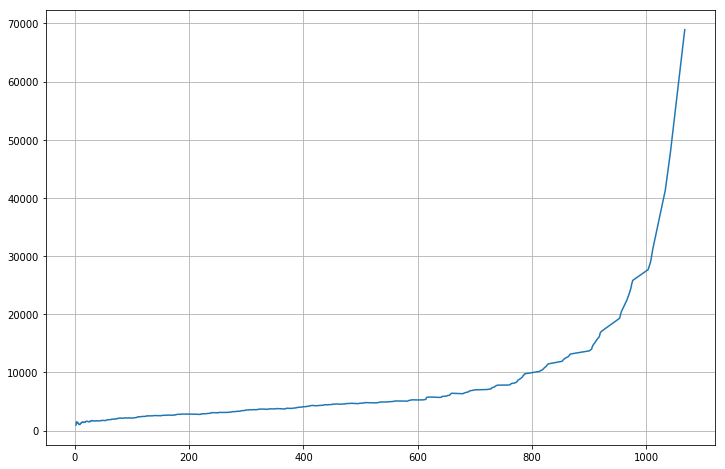

In [265]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, VRC_values)
plt.grid()
# plt.xlim(100,200)

### The silhouette

In [279]:
sscores = []
clust_sizes = range(2,len(z),1)
real_clust_sizes = []
last_k = -1
dist = pairwise_distances(scaffold_fps, metric='jaccard')
for n_clust in tqdm_notebook(clust_sizes):
    labels = fcluster(z, criterion='maxclust', t=n_clust)
    k = len(set(labels))
    if k == last_k:
#         VRC_values.append(VRC_values[-1])
        continue
    real_clust_sizes.append(k)
    last_k = k
    sscores.append(silhouette_score(dist, labels, metric='precomputed'))
    
sscores = np.asarray(sscores)

f:\programy\Miniconda3\envs\main\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


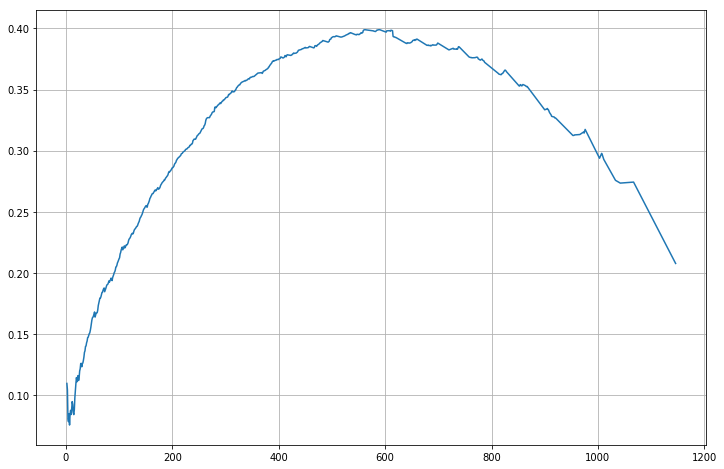

In [280]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, sscores)
plt.grid()
# plt.xlim(100,200)

In [306]:
n_clust_opt = real_clust_sizes[np.argmax(sscores)]
print('The optimal number of clusters is', n_clust_opt)

The optimal number of clusters is 587


## Setting for the number of clusters

In [320]:
labels = fcluster(z, criterion='maxclust', t=n_clust_opt)
display(np.max(labels))
label_names = np.asarray(['cluster_'+str(x) for x in labels])
df_scaffolds['cluster_label'] = label_names

587

Text(0.5, 1.0, 'Distribution of cluster sizes')

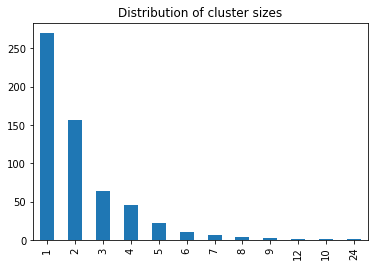

In [310]:
pd.Series(labels).value_counts().value_counts().plot(kind='bar')
plt.title('Distribution of cluster sizes')

## Clustering visualization

In [103]:
scaffolds_pca = PCA(2).fit_transform(scaffold_fps)
scaffold_mds = MDS(eps=1e-1, max_iter=50).fit_transform(scaffold_fps)
scaffolds_tsne = TSNE().fit_transform(scaffold_fps)

In [311]:
def make_colormap_cycle(x):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    return [colors[a%len(colors)] for a in x]

Text(0.5, 1.0, 'PCA')

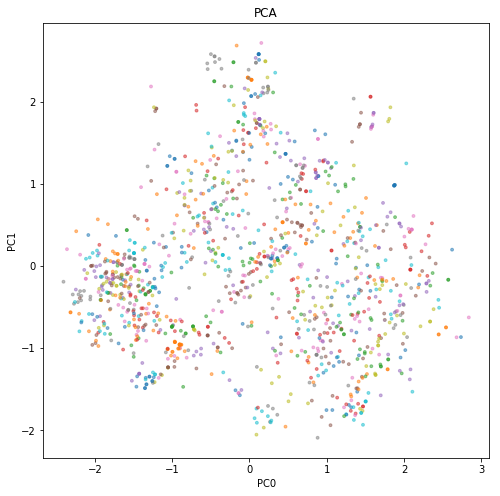

In [315]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_pca[mask,0], scaffolds_pca[mask,1], alpha=0.5, s=8, c=make_colormap_cycle(labels[mask]))
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PCA')

Text(0.5, 1.0, 'MDS')

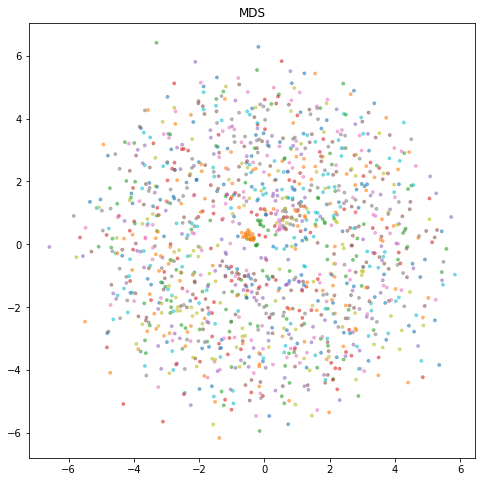

In [316]:
plt.figure(figsize=(8,8))
plt.scatter(scaffold_mds[mask,0], scaffold_mds[mask,1], alpha=0.5, s=8, c=make_colormap_cycle(labels[mask]))
plt.title('MDS')

Text(0.5, 1.0, 'tSNE')

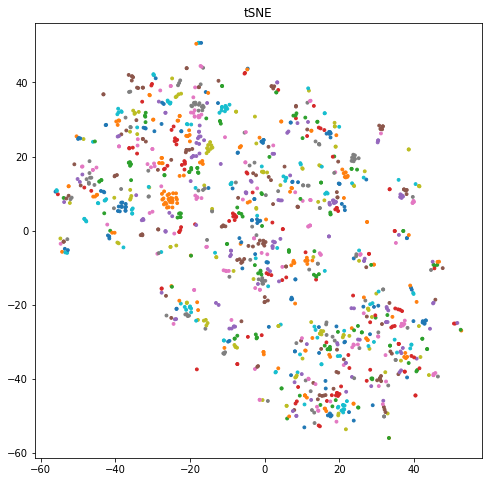

In [317]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_tsne[:,0], scaffolds_tsne[:,1], alpha=1.0, s=8, c=make_colormap_cycle(labels))
plt.title('tSNE')

## Visualizing few clusters

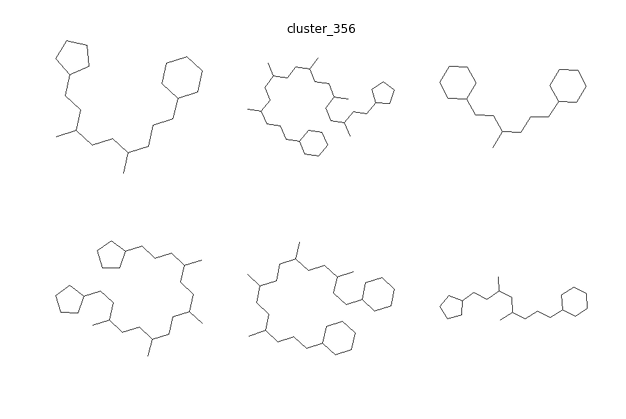

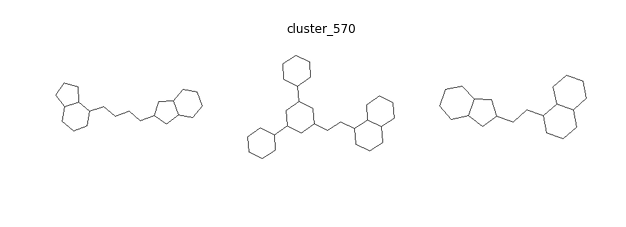

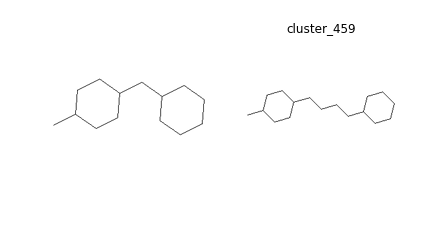

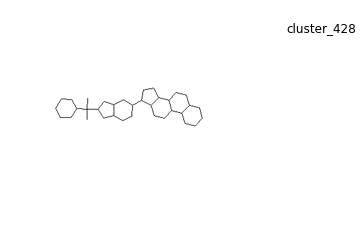

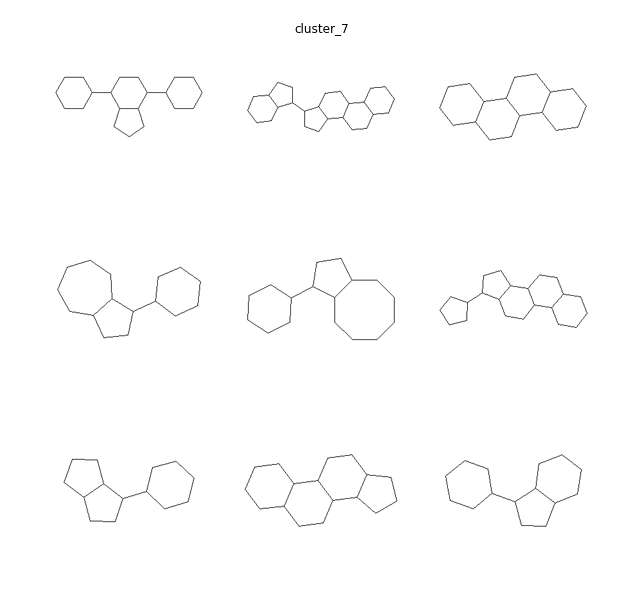

In [322]:
for c in np.random.choice(label_names,size=5,replace=False):
    mols = df_scaffolds.query('cluster_label == "%s"' % c)['mol']
    picked_scaffolds = np.random.choice(mols, size=min(9,len(mols)), replace=False)
#     img = Chem.Draw.MolsToGridImage(picked_scaffolds, subImgSize=(250,250))
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(c)
    for i in range(len(picked_scaffolds)):
        plt.subplot(3,3,i+1)
        img = Chem.Draw.MolToImage(picked_scaffolds[i], fitImage=True)
        plt.axis('off')
        plt.imshow(img, aspect='equal', interpolation='spline16')
    fig.tight_layout()
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

## ANOVA on clusters

In [323]:
df_era_scaffolds = df_era.join(df_scaffolds.set_index('scaffold_smiles'), on='scaffold_smiles', lsuffix='_l')

In [324]:
mod = ols('activity ~ cluster_label', data=df_era_scaffolds).fit()

In [325]:
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
cluster_label,377.0,3101.981155,8.228067,10.530642,9.315241e-281
Residual,1934.0,1511.121698,0.781345,NaN,NaN
